Klasyfikacja na podstawie modelu regresji:
              precision    recall  f1-score   support

       cheap       1.00      0.11      0.20       825
     average       0.00      0.00      0.00         0
   expensive       0.00      0.00      0.00         0

    accuracy                           0.11       825
   macro avg       0.33      0.04      0.07       825
weighted avg       1.00      0.11      0.20       825



/home/bilski/.local/share/virtualenvs/HousingPriceNeuralNet-87tFe-kd/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bilski/.local/share/virtualenvs/HousingPriceNeuralNet-87tFe-kd/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bilski/.local/share/virtualenvs/HousingPriceNeuralNet-87tFe-kd/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` paramete

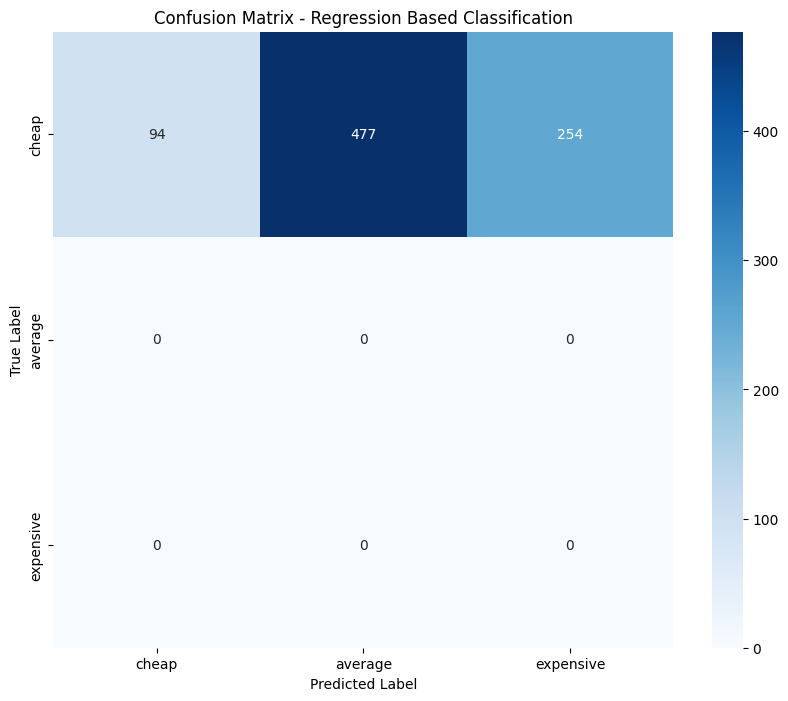


Dokładność per klasa:
cheap accuracy: 0.1139 (count: 825)
average accuracy: 0.0000 (count: 0)
expensive accuracy: 0.0000 (count: 0)

Rozkład cen w przypadku błędnych klasyfikacji:
True class: cheap -> Predicted: average
  Count: 477
  Avg predicted price: $182209.78
  Avg true price: $0.91
  Avg price difference: $182208.88
True class: cheap -> Predicted: expensive
  Count: 254
  Avg predicted price: $324622.53
  Avg true price: $1.44
  Avg price difference: $324621.03


Standardowa klasyfikacja:
              precision    recall  f1-score   support

       cheap       0.57      0.98      0.72       112
     average       0.99      0.69      0.81       599
   expensive       0.52      0.97      0.68       114

    accuracy                           0.77       825
   macro avg       0.69      0.88      0.74       825
weighted avg       0.87      0.77      0.78       825


Klasyfikacja z dostosowanymi progami:
              precision    recall  f1-score   support

       cheap       0.39      0.98      0.56       112
     average       0.99      0.71      0.83       599
   expensive       0.74      0.72      0.73       114

    accuracy                           0.75       825
   macro avg       0.70      0.80      0.70       825
weighted avg       0.87      0.75      0.78       825



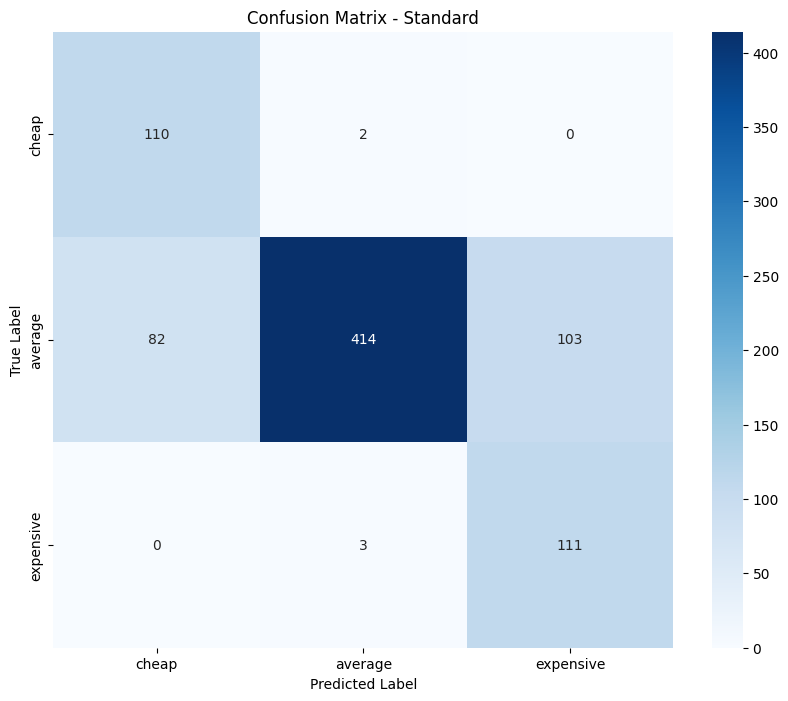

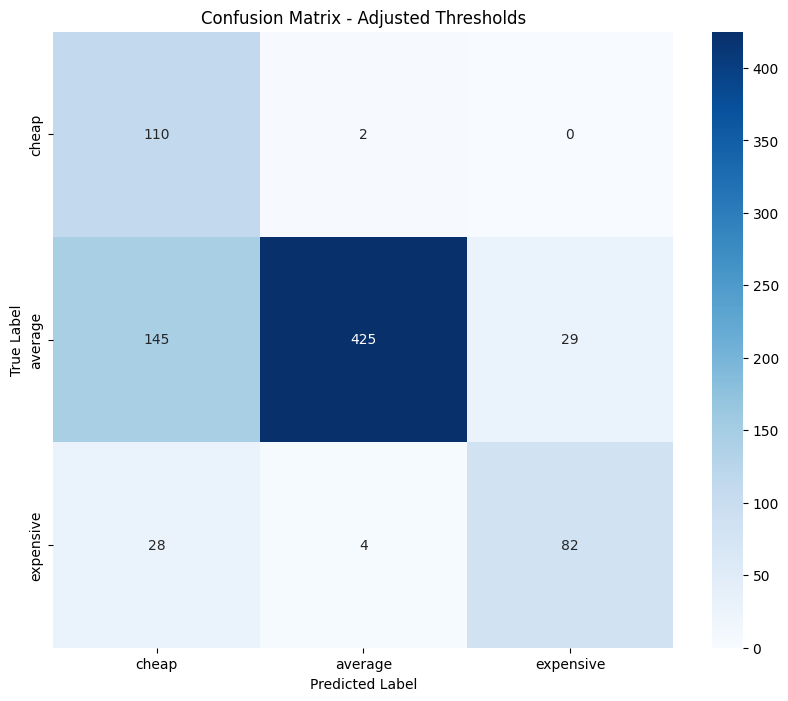


Dokładność per klasa - Standardowa klasyfikacja:
cheap accuracy: 0.9821
average accuracy: 0.6912
expensive accuracy: 0.9737

Dokładność per klasa - Klasyfikacja z dostosowanymi progami:
cheap accuracy: 0.9821
average accuracy: 0.7095
expensive accuracy: 0.7193


In [60]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from loguru import logger
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from housing_price_neural_net.config import MODELS_DIR
from housing_price_neural_net.modeling.train import HousePriceNet

# Funkcja do przewidywania z dostosowanymi progami
def predict_with_adjusted_thresholds(model, X, thresholds=[0.15, 0.5, 0.15]):
    with torch.no_grad():
        outputs = model(X)
        probabilities = F.softmax(outputs, dim=1)
        # Zastosuj niestandardowe progi
        adjusted_probs = probabilities.clone()
        for i, threshold in enumerate(thresholds):
            adjusted_probs[:, i] = (probabilities[:, i] >= threshold).float() * probabilities[:, i]
        return torch.argmax(adjusted_probs, dim=1)

val_data = np.load(MODELS_DIR / "val_data.npz")
X_val = val_data['X_val']
y_val = val_data['y_val']
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HousePriceNet(input_size=X_val.shape[1]).to(device)
model.load_state_dict(torch.load(MODELS_DIR / "model.pth"))
model.eval()

# Standardowa ewaluacja
y_pred_standard = []
y_true = []
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_standard.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.numpy())
y_pred_standard = np.array(y_pred_standard)
y_true = np.array(y_true)

# Ewaluacja z dostosowanymi progami
y_pred_adjusted = []
for batch_X, batch_y in val_loader:
    batch_X = batch_X.to(device)
    predicted = predict_with_adjusted_thresholds(model, batch_X, thresholds=[0.9, 0.45, 0.9])
    y_pred_adjusted.extend(predicted.cpu().numpy())
y_pred_adjusted = np.array(y_pred_adjusted)

# Porównanie wyników
print("Standardowa klasyfikacja:")
print(classification_report(y_true, y_pred_standard, target_names=['cheap', 'average', 'expensive']))

print("\nKlasyfikacja z dostosowanymi progami:")
print(classification_report(y_true, y_pred_adjusted, target_names=['cheap', 'average', 'expensive']))

# Wizualizacja macierzy pomyłek dla standardowej klasyfikacji
plt.figure(figsize=(10, 8))
cm_standard = confusion_matrix(y_true, y_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues',
            xticklabels=['cheap', 'average', 'expensive'],
            yticklabels=['cheap', 'average', 'expensive'])
plt.title('Confusion Matrix - Standard')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_standard.png')
plt.show()

# Wizualizacja macierzy pomyłek dla klasyfikacji z dostosowanymi progami
plt.figure(figsize=(10, 8))
cm_adjusted = confusion_matrix(y_true, y_pred_adjusted)
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['cheap', 'average', 'expensive'],
            yticklabels=['cheap', 'average', 'expensive'])
plt.title('Confusion Matrix - Adjusted Thresholds')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_adjusted.png')
plt.show()

# Sprawdzenie dokładności dla poszczególnych klas
print("\nDokładność per klasa - Standardowa klasyfikacja:")
for i, class_name in enumerate(['cheap', 'average', 'expensive']):
    class_mask = y_true == i
    class_acc = np.mean(y_pred_standard[class_mask] == y_true[class_mask])
    print(f"{class_name} accuracy: {class_acc:.4f}")

print("\nDokładność per klasa - Klasyfikacja z dostosowanymi progami:")
for i, class_name in enumerate(['cheap', 'average', 'expensive']):
    class_mask = y_true == i
    class_acc = np.mean(y_pred_adjusted[class_mask] == y_true[class_mask])
    print(f"{class_name} accuracy: {class_acc:.4f}")